In [38]:
import pandas as pd

data_df = pd.read_csv('keyword_emotion_sentence_only_train.csv')

In [39]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42874 entries, 0 to 42873
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42874 non-null  int64 
 1   상황키워드       42874 non-null  object
 2   감정_대분류      42874 non-null  object
 3   사람문장        42874 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [40]:
data_df['사람문장'] = data_df['사람문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


/var/folders/s0/5rhprztj2xs1kzwd87bwg_y00000gn/T/ipykernel_70112/1986910390.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['사람문장'] = data_df['사람문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [41]:
data_df['사람문장'].head(10)

0    일은 왜 해도 해도 끝이 없을까 화가 난다 그냥 내가 해결하는 게 나아 남들한테 부...
1    이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나 최...
2    회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...
3    직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 데 정말 분하고 섭...
4    얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나 상사인 나에게 먼...
5    직장에 다니고 있지만 시간만 버리는 거 같아 진지하게 진로에 대한 고민이 생겨 직장...
6    성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔 나도 섭섭해 부모님께 좀 ...
7    퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고 더 좋은 회사가 기다리고 있을지...
8    졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어 응 느긋함...
9    요즘 직장생활이 너무 편하고 좋은 것 같아 우리 회사는 복지가 정말 좋아 내가 곧 ...
Name: 사람문장, dtype: object

# 1. 감정 분류

In [42]:
emo_df = data_df

In [43]:
emo_target_df = emo_df['감정_대분류']

In [44]:
emo_sentence_df = emo_df['사람문장']

In [45]:
emo_target_df.value_counts()

불안    9320
분노    9160
상처    9143
슬픔    9125
기쁨    6126
Name: 감정_대분류, dtype: int64

In [46]:
type(emo_target_df)

pandas.core.series.Series

In [47]:
emo_df.loc[(emo_df['감정_대분류']=='불안'), '감정_대분류'] = 0
emo_df.loc[(emo_df['감정_대분류']=='분노'), '감정_대분류'] = 1
emo_df.loc[(emo_df['감정_대분류']=='상처'), '감정_대분류'] = 2 
emo_df.loc[(emo_df['감정_대분류']=='슬픔'), '감정_대분류'] = 3 
emo_df.loc[(emo_df['감정_대분류']=='기쁨'), '감정_대분류'] = 4 

In [48]:
emo_target_df = emo_df['감정_대분류']

In [49]:
emo_target_df.value_counts()

0    9320
1    9160
2    9143
3    9125
4    6126
Name: 감정_대분류, dtype: int64

In [50]:
from konlpy.tag import Okt
from tqdm import tqdm


In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [52]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [53]:
okt = Okt()

In [54]:
tokenized_X_train = []

for sentence in tqdm(emo_df['사람문장']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_X_train.append(stopwords_removed_sentence)

100%|██████████| 42874/42874 [01:54<00:00, 372.83it/s]


In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_X_train)

In [ ]:
print(tokenizer.word_index)

In [58]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 14182
등장 빈도가 2번 이하인 희귀 단어의 수: 5669
단어 집합에서 희귀 단어의 비율: 39.97320547172472
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.5732984700627227


In [59]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8514


In [60]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(tokenized_X_train)
X_train = tokenizer.texts_to_sequences(tokenized_X_train)

In [61]:
import numpy as np

y_train = np.array(emo_target_df)

In [62]:
y_train

array([1, 1, 1, ..., 2, 0, 2], dtype=object)

최대 길이 : 92
평균 길이 : 29.80018192844148


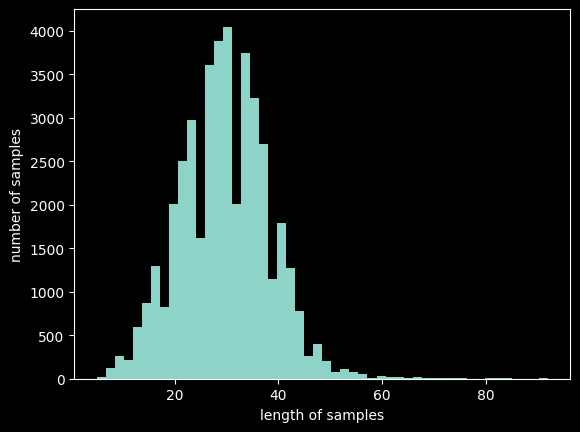

In [63]:
import matplotlib.pyplot as plt

print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [64]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [65]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.79880580305081


In [66]:
X_train = pad_sequences(X_train, maxlen=max_len)


In [67]:
len(y_train)

42874

In [68]:
len(X_train)

42874

In [69]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
y_train = y_train.astype(int)

In [71]:
pd.Series(y_train).value_counts()

0    9320
1    9160
2    9143
3    9125
4    6126
dtype: int64

In [72]:
num = np.unique(y_train, axis=0)
num = num.shape[0]
one_hot_y_train = np.eye(num)[y_train]
one_hot_y_train

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [73]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(5, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, one_hot_y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/50


2023-03-02 20:08:55.432752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 20:08:55.635966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 20:08:55.824000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


536/536 [==============================] - ETA: 0s - loss: 1.0874 - acc: 0.5668

2023-03-02 20:09:14.833060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 20:09:14.905068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.46286, saving model to best_model.h5
536/536 [==============================] - 23s 40ms/step - loss: 1.0874 - acc: 0.5668 - val_loss: 1.2915 - val_acc: 0.4629
Epoch 2/50
536/536 [==============================] - ETA: 0s - loss: 0.7902 - acc: 0.7170
Epoch 2: val_acc improved from 0.46286 to 0.51090, saving model to best_model.h5
536/536 [==============================] - 20s 36ms/step - loss: 0.7902 - acc: 0.7170 - val_loss: 1.2489 - val_acc: 0.5109
Epoch 3/50
536/536 [==============================] - ETA: 0s - loss: 0.6902 - acc: 0.7586
Epoch 3: val_acc did not improve from 0.51090
536/536 [==============================] - 20s 36ms/step - loss: 0.6902 - acc: 0.7586 - val_loss: 1.3050 - val_acc: 0.4864
Epoch 4/50
535/536 [============================>.] - ETA: 0s - loss: 0.6171 - acc: 0.7878
Epoch 4: val_acc did not improve from 0.51090
536/536 [==============================] - 19s 35ms/step - loss: 0.6170 - acc: 0.7878 - val_loss: 1.3852 -

In [74]:
loaded_model = load_model('best_model.h5')

In [75]:
import re

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(np.argmax(loaded_model.predict(pad_new), axis=-1)) # 예측
  if score == 0:
    print('불안')
  elif score == 1:
    print('분노')
  elif score == 2:
    print('상처')
  elif score == 3:
    print('슬픔')
  elif score == 4:
    print('기쁨')
  # print(f'score = {score}')

In [76]:
sentiment_predict('화나')


2023-03-02 20:10:55.260408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 20:10:55.330283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
분노


In [77]:
sentiment_predict('기뻐')

1/1 [==============================] - 0s 23ms/step
기쁨


In [78]:
sentiment_predict('슬퍼')

1/1 [==============================] - 0s 21ms/step
슬픔


In [79]:
sentiment_predict('나는 오늘 밥을 먹었어')

1/1 [==============================] - 0s 17ms/step
기쁨


In [100]:
sentiment_predict('배고픔을 채우기보다 즐거움을 채우기 위해')

1/1 [==============================] - 0s 52ms/step
기쁨


In [81]:
sentiment_predict('생일 축하해')

1/1 [==============================] - 0s 16ms/step
기쁨


In [106]:
sentiment_predict('나 연애 언제하는지좀 물어봐줘')

1/1 [==============================] - 0s 60ms/step
불안


In [82]:
sentiment_predict('나 지금 행복해')

1/1 [==============================] - 0s 17ms/step
기쁨


In [83]:
sentiment_predict('나 지금 밥먹을거거든')

1/1 [==============================] - 0s 19ms/step
기쁨


In [84]:
sentiment_predict('으악')

1/1 [==============================] - 0s 22ms/step
기쁨


In [85]:
sentiment_predict('종강은 언제오나')

1/1 [==============================] - 0s 17ms/step
분노


In [86]:
sentiment_predict('엘리베이터에 갇혔어')

1/1 [==============================] - 0s 19ms/step
상처


In [87]:
sentiment_predict('프로젝트 하고 있어')

1/1 [==============================] - 0s 16ms/step
기쁨


In [88]:
sentiment_predict('엄마가 피부과 빨리 갔다오래')

1/1 [==============================] - 0s 17ms/step
상처


In [89]:
sentiment_predict('쉽지 않아')

1/1 [==============================] - 0s 17ms/step
상처


In [90]:
sentiment_predict('아이유랑 결혼하고싶어')

1/1 [==============================] - 0s 17ms/step
기쁨


In [91]:
sentiment_predict('집에 가고 싶은데')

1/1 [==============================] - 0s 27ms/step
기쁨


In [92]:
sentiment_predict('나 내일 군대가')

1/1 [==============================] - 0s 16ms/step
불안


In [93]:
sentiment_predict('선임이 괴롭혀')

1/1 [==============================] - 0s 16ms/step
분노


In [94]:
sentiment_predict('시끄러워 죽겠어')

1/1 [==============================] - 0s 16ms/step
상처


In [95]:
sentiment_predict('아 열받네')

1/1 [==============================] - 0s 19ms/step
분노


In [96]:
sentiment_predict('나 오늘 배신당했어')

1/1 [==============================] - 0s 16ms/step
상처


In [107]:
sentiment_predict('나 오늘 배신당했어')

1/1 [==============================] - 0s 84ms/step
상처


In [108]:
sentiment_predict('100일')

1/1 [==============================] - 0s 40ms/step
기쁨


In [109]:
sentiment_predict('너랑 나랑 사귄지 벌써 100일이야')

1/1 [==============================] - 0s 74ms/step
기쁨


In [110]:
sentiment_predict('나랑 함께해줘서 고마워')

1/1 [==============================] - 0s 60ms/step
기쁨


In [112]:
sentiment_predict('스카이넷 초기모델이 나올거같은데')

1/1 [==============================] - 0s 78ms/step
기쁨


In [113]:
test_val_df = pd.read_csv('keyword_emotion_sentence_only_validation.csv')

In [115]:
test_list = []
for sentence in tqdm(test_val_df['사람문장']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    test_list.append(stopwords_removed_sentence)

100%|██████████| 5593/5593 [00:18<00:00, 309.98it/s]


In [116]:
X_test = tokenizer.texts_to_sequences(test_list)
X_test = pad_sequences(X_test, maxlen=max_len)

In [117]:
y_pred = loaded_model.predict(X_test)

175/175 [==============================] - 3s 14ms/step


In [120]:
tmp = np.argmax(loaded_model.predict(X_test), axis=-1) # 예측


175/175 [==============================] - 2s 10ms/step


In [122]:
test_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593 entries, 0 to 5592
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5593 non-null   int64 
 1   상황키워드       5593 non-null   object
 2   감정_대분류      5593 non-null   object
 3   사람문장        5593 non-null   object
dtypes: int64(1), object(3)
memory usage: 174.9+ KB


In [123]:
test_val_df['추정_감정_대분류'] = pd.DataFrame(tmp)

In [ ]:
def num_to_emo(number):
    if number == 0:
        return '불안'
    elif number == 1:
        return '분노'
    elif number == 1:
        return '상처'
    elif number == 1:
        return '슬품'
    el number == 1:
        return '기쁨'

In [124]:
test_val_df.apply()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593 entries, 0 to 5592
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5593 non-null   int64 
 1   상황키워드       5593 non-null   object
 2   감정_대분류      5593 non-null   object
 3   사람문장        5593 non-null   object
 4   추정_감정_대분류   5593 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 218.6+ KB


In [125]:
test_val_df.to_csv('tmp_val_data.csv')